Naszym zadaniem jest przeanalizowanie zbioru danych medycznych oraz stworzenia modelu klasyfikującego potencjalnego pacjenta ze względu na fakt wystąpienia udaru mózgu.

Udar mózgu to zespół objawów klinicznych związanych z nagłym wystąpieniem ogniskowego lub uogólnionego zaburzenia czynności mózgu, powstały w wyniku zaburzenia krążenia mózgowego i utrzymującego się ponad 24 godziny.

# Biblioteki

In [71]:
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# Funkcje

In [85]:
def plotting(data: pd.DataFrame, x: str, type: str, y=None, cl = 'stroke'):
  """
    Function for plotting data in specific way

  Args:
    data - dataset to plot

    x - column for x-axis
    
    y - column for y-axis
    
    type - type of plot 
      values: {'hist', 'box', 'hist_box', 'class_hist', 'class_box', 'class_hist_box', 'scatter', 'heatmap'} 

    cl - class

  Returns:
    Plot in plotly
  """

  def plot_class_hist():
    """
      Plots histogram with stroke classes in plotly
    """
    
    fig = go.Figure()
    fig.add_trace(go.Histogram(x = data.loc[data[cl]==0, x], name='No '+cl))
    fig.add_trace(go.Histogram(x = data.loc[data[cl]==1, x], name=cl))

    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    
    return fig
  
  def plot_class_box():
    """
      Plots boxplot with stroke classes in plotly
    """
    
    fig = go.Figure()
    fig.add_trace(go.Box(y = data.loc[data[cl]==0, x], name='No '+cl))
    fig.add_trace(go.Box(y = data.loc[data[cl]==1, x], name=cl))

    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    
    return fig
    

  if type=='hist':
    fig = px.histogram(data, x=x)
    fig.show()

  elif type=='box':
    fig = px.box(data, x=x)
    fig.show()
  
  elif type=='scatter':
    data['temp'] = data[cl].astype('str')

    fig = px.scatter(data, x=x, y=y, color='temp')
    fig.update_layout(title_text="Scatterplot for " + x)
    fig.update_traces(marker_size=10)
    
    fig.show()
  
  elif type=='heatmap':
    corr = data.corr()
    f, ax = plt.subplots(figsize=(16, 12))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

  elif type=='hist_box':
    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(go.Histogram(x = data[x], name=x), row=1,col=1)
    fig.add_trace(go.Box(y = data[x], name=x), row=1, col=2)
    
    fig.update_layout(barmode="overlay")
    fig.update_traces(opacity=0.7, row=1, col=1)
    fig.update_layout(title_text="Histogram and Boxplot for " + x)
    fig.show()

  elif type=='class_hist':
    
    fig = plot_class_hist()
    fig.show()
  
  elif type=='class_box':
    
    fig = plot_class_box()
    fig.show()

  elif type=='class_hist_box':
    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(go.Histogram(x = data.loc[data[cl]==0, x], name='No '+cl), row=1,col=1)
    fig.add_trace(go.Histogram(x = data.loc[data[cl]==1, x], name=cl), row=1, col=1)
    fig.add_trace(go.Box(y = data.loc[data[cl]==0, x], name='No '+cl), row=1, col=2)
    fig.add_trace(go.Box(y = data.loc[data[cl]==1, x], name=cl), row=1, col=2)

    fig.update_layout(barmode="overlay")
    fig.update_traces(opacity=0.7, row=1, col=1)
    fig.update_layout(title_text="Histogram and Boxplot with classes for " + x)
    fig.show()

  else:
    raise NotImplementedError('Not implemented!')

  return 0

In [ ]:
def iqr_outliers(df: pd.DataFrame, col: str):
  """
  Function for managin outliers in given column from dataframe using IQR method. 
  In descriptive statistics, the interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data. 
  It is defined as the difference between the 75th and 25th percentiles of the data.

  Args:
    df - dataset to remove outliers

    col - column for removing outliers
    
  Returns:
    Whole dataframe with specified column cleaned from outliers using IQR method

  """
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  df.loc[df[col] <= Q1 - 1.5*IQR, col] = df[col].quantile(0.1)
  df.loc[df[col] >= Q3 + 1.5*IQR, col] = df[col].quantile(0.9)

  return df

In [56]:
def balance_data(X, y, algorithm, strategy=0.5, seed = 123):
  """
  Function for balancing dataset using specified algorithm and sampling strategy. 

  Args:
    X - matrix of features

    y - vector of target variable observations

    algorithm - algorithm for balancing dataset
      values: {'SMOTE', 'ADASYN', 'SMOTETOMEK', 'SMOTEENN'}

    strategy - sampling information to resample the data set

  Returns:
    Whole balanced dataframe 
  """

  if algorithm == 'SMOTE':
    bs = SMOTE(sampling_strategy = strategy)

  elif algorithm == 'ADASYN':
    bs = ADASYN(random_state = seed, sampling_strategy = strategy)

  elif algorithm == 'SMOTETOMEK':
    bs = SMOTETomek(random_state = seed, sampling_strategy = strategy)

  elif algorithm == 'SMOTEENN':
    bs = SMOTEENN(sampling_strategy = strategy)
  
  else:
    raise NotImplementedError('Not implemented!')

  X_bs,  y_bs = bs.fit_resample(X, y)

  df_bs = X_bs.copy()
  df_bs['stroke'] = y_bs


  print("Procent klasy mniejszościowej do całości po zbalansowaniu: ", len(y_bs[y_bs == 1])/len(y_bs))
  
  return df_bs

# Dane

In [ ]:
url = 'https://github.com/maju116/Statistics_II_GUT/raw/main/PROJECT/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(url)

df.head(5)

In [ ]:
df.info()

In [ ]:
df.describe().transpose()

Mamy łącznie 12 kolumn po 5110 obserwacji z czego jedna z nich stanowi ('stroke') zmienną celu i będziemy starać się ja zamodelować. Jest to zmienna binarna informująca czy dany pacjent miał udar mózgu czy też nie zatem jest to typowe zadanie klasyfikujące. Oprócz tego jest pozostałych 11 zmiennych:
- zmienna **id** typu integer przypisująca konkretnego pacjenta nie wnosi raczej żadnej wartości informacyjnej ale pozwoli nam sprawdzić czy jakiś pacjent jest dwukrotnie w historii co mogłoby wskazywać na podwyższone ryzyko udaru.
- zmienna **gender** typu object jest zmienną binarną wskazująca na płeć pacjenta, z pewnością będzie trzeba ją zakodować. Spodziewa się, iż będzie dawała istotną informacje dla zmiennej celu. 
- zmienna **age** typu float jest zmienną numeryczną wskazująca na wiek pacjenta i także można się spodziewać że będzie istotna w modelowaniu. Mamy tutaj zakres wartości od 25 do 82 bez raczej mocnych ogonów.
- zmienna **hypertension** typu integer jest zmienną binarną informująca o nadciśnieniu pacjenta.
- zmienna **heart_disease** typu integer jest zmienną binarną informująca o występowaniu chorób serca.
- zmienna **ever_married** typu object jest zmienną kategoryczną informująca o tym czy pacjent kiedykolwiek był w związku małżeńskim.
- zmienna **work_type** typu object jest zmienną kategoryczną informująca o typie zatrudnieniu.
- zmienna **residence_type** typu object jest zmienną kategoryczną informująca o strukturze miejsca zamieszkania.
- zmienna **avg_glucose_level** typu float jest zmienną numeryczną informująca o przeciętnyn poziomie glukozy we krwi.
- zmienna **bmi** typu float jest zmienną numeryczną informująca o wskaźniku BMI pacjenta. Posiada 201 braków danych.
- zmienna **smoking_status** typu object jest zmienną kategoryczną informująca o tym czy i jak często palił pacjent.
- zmienna **stroke** typu int jest zmienną binarną informująca czy pacjent doznał udaru mózgu i jest to nasza zmienną celu.

Widzimy, że mamy 211 braków danych dla zmiennej **bmi**, którymi zajmiemy się w dalszej części projektu.

# EDA

### stroke

In [ ]:
df.stroke.value_counts()

In [ ]:
plotting(df, 'stroke', type = 'hist')

Widzimy, że nasza zmienna celu jest niezbalansowana gdzie klasą większościową są pacjenci bez udaru mózgu. Musimy mieć to na uwadze i w przypadku pozostawienia takiego stanu rzeczy nie możemy skorzystać z metryki **accuracy**, a powinniśmy skorzystać z innej - przykładowo średniej harmonicznej między **precision** a **recall** czyli **f1-score**. Niezbalansowany zbiór danych jest jednak dość problemtyczny, gdyż klasyfikator ma tendencję skupiania się na predykcji klasy większościowej. 

Istnieją sposoby na zbalansowanie zbioru danych, które są częścią **pre-processingu** czyli wstępnego przetwarzania danych przed modelowaniem. Do jednych z bardziej popularnych metod należą:
- **undersampling** - pozostawia wszystkie obserwacje z klasy mniejszościowej i losowo eliminuje obiekty z klasy większościowej
- **oversampling** - pozostawia wszystkie obserwacje z klasy większościowej i losowo replikuje elementy z klasy mniejszościowej

W przypadku undersamplingu możemy pozbyć się istotnych informacyjnie obserwacji. Dodatkowo nasz zbiór danych jest niewielki, więc nie chcielibyśmy się ograniczyć do zaledwie 249 obserwacji. Natomiast oversampling może doprowadzić do nadmiernego dopasowania modelu do naszych danych. Istnieje też podejście mieszane wykorzystujące zarówno undersampling, jak też oversampling ale ciężko jest ustalić optymalną proporcję między podejściami. Spróbujemy sprawdzić empirycznie najlepszą metodę i się do niej ograniczyć oczywiście opierając się nie o zwykłe próbkowanie, a dostępne i znane algorytmu balansowania zbiorów danych.

### id

In [ ]:
print("Liczba zduplikowanych wartości ID pacjentów: ", len(df[df.id.duplicated()]))

W naszym zbiorze danych każdy pacjent jest wpisany unikalnie, tak więc zmienna ID raczej do niczego więcej nam się nie przyda i będziemy mogli ją pozostawić w dalszych etapach. 

### gender

In [ ]:
plotting(data = df, x='gender',  type='class_hist')

In [ ]:
df.gender.value_counts()

W zmiennej gender występują 3 wartości (male, female, other). Wartość 'Other' występuje tylko jeden raz, więc można go potraktować jako brak danych. W zależności od wartości pozostałych zmiennej dla tej obserwacji albo zastąpimy ją wartością male lub female (jako tą która najczęściej występuje) albo usuniemy.

### age

In [ ]:
plotting(data = df, x='age',  type='hist_box')

In [ ]:
plotting(data = df, x='age',  type='class_hist_box')

Możemy zaobserwować, że udar mózgu w naszym zbiorze mają głównie osoby w podeszłym wieku (60-80 lat). Natomiast osoby bez udaru rozkładają się dość równomiernie, mediana wynosi 43 lata, gdzie dla osób z udarem 71 lat. Dodatkowo występują zmienne odstające w grupie ludzi z udarem. Sam rozkład zmiennej zbliżony jest do rozkładu jednostajnego. 

### hypertension

In [ ]:
plotting(data = df, x='hypertension',  type='class_hist')

Można zauważyć, że znaczna większość pacjentów nie ma nadciśnienia. Co więcej, mimo braku zbalansowanego zbioru danych, więcej pacjentów z udarem mózgu nie miało przy tym nadciśnienia. 

### heart_disease

In [ ]:
plotting(data = df, x='heart_disaease',  type='class_hist')

Podobna sytuacja jak dla zmiennej hypertension. Znaczna większość pacjentow nie ma chorób serca oraz mimo braku zbalansowania, większość osób z udarem także nie ma chorób serca. 

### ever_married

In [ ]:
plotting(data = df, x='ever_married',  type='class_hist')

Zmienna ever_married jest zmienną kategoryczną, którą będzie trzeba zakodować w wartości (0,1). Większa część pacjentów była kiedykolwiek żonata oraz to w tej grupie udar mózgu występuje w większej ilości. 

### work_type

In [ ]:
plotting(data = df, x='work_type',  type='class_hist')

Zmienna work_type określająca rodzaj wykonywanej pracy jest także zmienną kategoryczną, którą zakodujemy w wartości numeryczne. Najwięcej pacjentów jest z kategorii 'private', następnie równiemiernie ilościowo rozłożeni między 'children', 'self_employed', 'govt_job'. Znikoma ilość nigdy nie pracowała. Największa ilość udarów znajduje się wśród sektora prywatnego oraz samo-zatrunionego. Niewielka część w sektorze publicznym. Pojedyncze wartości występują też w grupie dzieci, ale z poprzednich wniosków najprawdopodobniej są to obserwacje odstające. Można także spróbować zkoszykować tą zmienną i rozdzielić na sektor obciążony i nieobciążony względem ryzyka udaru mózgu. 

### residence_type

In [ ]:
plotting(data = df, x='Residence_type',  type='class_hist')

Zmienna określa obszar zamieszkania z rozdziałem na wiejski i miejski. Widać, że podział jest równomierny oraz w każdym z podziałów jest zbliżona proporcja osób po udarze do osób bez udaru mózgu, więc zmienna ta niesie ze sobą najpewniej niewielką ilość informacji dla potencjalnego modelu. 

### avg_glucose_level

In [ ]:
plotting(data = df, x='avg_glucose_level',  type='hist_box')

In [ ]:
plotting(data = df, x='avg_glucose_level',  type='class_hist_box')

Możemy zaobserwować, że najwięcej jest pacjentów ze średnim poziomem glukozy w przedziale 77.24 - I kwantyl, 114.09 - II kwantyl, a więc z poziomem prawidłowym lub stanem przedcukrzycowym. Wniosek ten jednak jest uogólniony, gdyż zakres ten jest nieco inny w zależności od pory czy też sposobu wykonywanego badania, a także wieku badanej osoby. Osoby z wyższym średnim poziomem glukozy we krwi są outlierami dla grupy bez udaru mózgu, natomiast dla pozostałej części osób mieszczą się one w IV kwantylu. Więc usunięcie tych obserwacji, lub też zmiana ich wartości spowodowałaby utratę być może znaczącej informacji. Zamiast tego spróbujemy wykorzystać tą zależność tworząc nową zmienną kategoryczną informującą o średnim zakresie glukozy (poziom prawidłowy, stan przedcukrzycowy, cukrzyca) oraz imputując nowe wartości, jak też transformując całą zmienną. 


### bmi

In [ ]:
plotting(data = df, x='bmi',  type='hist_box')

In [ ]:
plotting(data = df, x='bmi',  type='class_hist_box')

Rozkład zmiennej bmi przypomina rozkład normalny z cięższym prawym ogonem. Występują też outliery dla bmi > 47.5. Większość pacjentów zawiera się w przedziale 23.5 - 33.1 czyli jest z wagą prawidłową lub nadwagą I stopnia. O ile sama zmienna może nie nieść zbyt dużej informacji z uwagi, że rozkład wartości jest zbliżony dla osób z udarem, jak i bez udaru to niemniej możliwe są pewne istotne interakcje między pozostałymi zmiennymi jak chociażby średnim poziomem glukozy we krwi. W kontekście danych odstających również można stworzyć zmienną kategoryczną zgodnie z kategoriami wskaźników BMI.

Dodatkowo zmienna BMI zawiera braki danych, którymi należy się zająć. Istnieje na to wiele metod m.in. 
- usunięcie obserwacji
- wypełnienie ich statystyką opisową typu średnia, mediana
- wykorzystanie algorytmów ML takich jak KNN

Z racji, iż braków danych jest niewiele (zaledwie 4%) to wypełnimi ich statystyką opisową jako działaniem prostym, ale i skutecznym. Jak wspomniano, rozkład zmiennej jest zbliżony do normalnego więc nie ma większego znaczenia wybór między medianą, a średnią ale zważywszy na lekki ogon prawostronny wybrana zostanie mediana. Dla obserwacji odstających posłużymy się metodą IQR.

### smoking_status

In [ ]:
plotting(data = df, x='smoking_status',  type='class_hist_box')

Ciężko wyciągnać tu szersze wnioski zważywszy na dość liczną grupę 'Unknown', Najliczniejsza grupa pacjentów nigdy nie paliła papierosów zakładając, że w grupie 'Unknown' wartości rozkładałyby się w miare równomiernie. Widać rozróżnienei dla osób z udarem, że w większości są to osoby niepalące lub palące sporadycznie. 

# Inżynieria cech

W inżynierii cech będziemy tworzyli nowe zmienne z już istniejących, zajmowali się brakiem danych czy też odstającymi obserwacjami. Do tego ostatniego skorzystamy z metody rozstępu międzyćwiartylkowego IQR. Jest to różnica między trzecim a pierwszym kwartylem. Ponieważ pomiędzy tymi kwartylami znajduje się z definicji 50% wszystkich obserwacji (położonych centralnie w rozkładzie), dlatego im większa szerokość rozstępu ćwiartkowego, tym większe zróżnicowanie cechy. Dodatkowo na końcu dokonamy balansowania naszego zbioru z wykorzystaniem 4 technik: SMOTE, ADASYN, SMOTE+Tomek, SMOTE ENN. 

In [ ]:
#głęboka kopia danych

df_clear = df.copy()

### bmi

- imputacja braków danych przy użyciu mediany
- stworzenie nowej zmiennej kategorycznej na podstawie istniejącej zmiennej numerycznej oraz zakodowanie jej
- dodanie zmiennej numerycznej bez danych odstających poprzez wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl
- log-transformacja zmiennej oraz wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl

In [ ]:
#imputacja mediany w miejsca NA
df_clear['bmi_no_nan'] = df_clear.bmi.fillna(df_clear.bmi.median())

#nowa zmienna kategoryczna zgodnie ze wskaźnikami BMI
df_clear.loc[(df_clear.bmi_no_nan < 18.5), 'bmi_categorical'] = 'underweight'
df_clear.loc[(df_clear.bmi_no_nan >= 18.5) & (df_clear.bmi_no_nan <= 24.9), 'bmi_categorical'] = 'normal'
df_clear.loc[(df_clear.bmi_no_nan > 24.9) & (df_clear.bmi_no_nan <= 29.9), 'bmi_categorical'] = 'overweight'
df_clear.loc[(df_clear.bmi_no_nan > 29.9) & (df_clear.bmi_no_nan < 34.9), 'bmi_categorical'] = 'obese'
df_clear.loc[(df_clear.bmi_no_nan > 34.9), 'bmi_categorical'] = 'extremely obsese'

#zakodowanie
le_bmi = preprocessing.LabelEncoder()
le_bmi.fit(df_clear.bmi_categorical)
df_clear['bmi_categorical_encoded'] = le_bmi.transform(df_clear.bmi_categorical)
df_clear.info()

#zmienna numeryczna bez outlierów
df_clear['bmi_no_outliers'] = df_clear.bmi_no_nan
df_clear = iqr_outliers(df_clear, 'bmi_no_outliers')

#log-transformacja bez outlierów
df_clear['log_bmi_no_outliers'] = np.log(df_clear.bmi_no_nan)
df_clear = iqr_outliers(df_clear, 'log_bmi_no_outliers')

In [ ]:
for col, types in zip(['bmi_no_nan', 'bmi_categorical', 'bmi_no_outliers', 'log_bmi_no_outliers'], ['hist_box','class_hist','hist_box','hist_box']):
  plotting(data = df_clear, x=col, type=types)

Możemy zaobserwować, że wypełnienie braków danych spowodowało peak w punkcie mediany co jest naturalnym efektem zastosowanej metody. Dodatkowo, najbardziej liczna jest grupa osób z nadwagą i to tam również najliczniej występują osoby z udarem mózgu. W przypadku usunięcia outlierów mozemy zaobserwować pozbycie się ogona prawostronnego, natomiast zastosowanie log-transformacji wydaje się nie mieć znacznego wpływu poza przeskalowaniem co będzie zbędne z racji iż w późniejszym etapie będziemy dokonywać standaryzacji zmiennych. 

### gender
- z racji, iż jest to tylko jedna obserwacja i ciężko jest ją odpowiednio podmienić (pozostałe zmienne są mocno rozrzucone, więc nie niosą wystarczającej informacji do imputacji) zostanie usunięta
- kodowanie zmiennej

In [ ]:
df_clear = df_clear[df_clear.gender != 'Other']
df_clear.loc[df_clear.gender == 'Female', 'is_female'] = 1
df_clear.loc[df_clear.gender == 'Male', 'is_female'] = 0

df_clear.info()

### age
- pozbycie się outlierów dla klasy 'stroke', gdyż widać zróżnicowanie dla tej grupy i pozostawienie ich mogłoby wprowadzić zbędny szum

In [ ]:
#tablica z pacjentami z udarem
df_stroke = df_clear[df_clear.stroke == 1].copy()
#pozbycie sie outlierow
df_stroke = iqr_outliers(df=df_stroke, col='age')
#ponowna konkatenacja zbioru
df_clear = pd.concat([df_clear[df_clear.stroke==0], df_stroke])
#plot
plotting(data=df_clear, x='age', type='class_hist_box')
#podsumowanie
df_clear.info()

### ever_married
- zakodowanie zmiennej

In [ ]:
df_clear.loc[df_clear.ever_married == 'Yes', 'ever_married'] = 1
df_clear.loc[df_clear.ever_married == 'No', 'ever_married'] = 0

df_clear.info()

### work_type
- zakodowanie zmiennej

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_clear.work_type)
df_clear['work_type_encoded'] = le.transform(df_clear.work_type)
df_clear.info()

### Residence_type
- zakodowanie zmiennej

In [ ]:
df_clear.loc[df_clear.Residence_type == 'Rural', 'is_rural'] = 1
df_clear.loc[df_clear.Residence_type == 'Urban', 'is_rural'] = 0 
df_clear.info()

### avg_glucose_level
- stworzenie nowej zmiennej kategorycznej na podstawie istniejącej zmiennej numerycznej oraz zakodowanie jej
- dodanie zmiennej numerycznej bez danych odstających poprzez wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl
- log-transformacja zmiennej oraz wykrycie ich metodą IQR oraz ograniczenie ich wartości na 0.9 kwantyl oraz 0.1 kwantyl

In [ ]:
#nowa zmienna kategoryczna zgodnie ze wskaźnikami BMI
df_clear.loc[(df_clear.avg_glucose_level < 140), 'glucose_categorical'] = 'normal'
df_clear.loc[(df_clear.avg_glucose_level >= 140) & (df_clear.avg_glucose_level <= 199), 'glucose_categorical'] = 'prediabetes'
df_clear.loc[(df_clear.avg_glucose_level > 199), 'glucose_categorical'] = 'diabetes'

#kodowanie
le_gl = preprocessing.LabelEncoder()
le_gl.fit(df_clear.glucose_categorical)
df_clear['glucose_categorical_encoded'] = le_gl.transform(df_clear.glucose_categorical)
df_clear.info()

#zmienna numeryczna bez outlierów
df_clear['glucose_no_outliers'] = df_clear.avg_glucose_level
df_clear = iqr_outliers(df_clear, 'glucose_no_outliers')

#log-transformacja bez outlierów
df_clear['log_glucose_no_outliers'] = np.log(df_clear.avg_glucose_level)
df_clear = iqr_outliers(df_clear, 'log_glucose_no_outliers')

In [ ]:
for col, types in zip(['glucose_categorical', 'glucose_no_outliers', 'log_glucose_no_outliers'], ['class_hist','class_hist_box','class_hist_box']):
  plotting(data = df_clear, x=col, type=types)

Najbardziej liczna jest grupa osób z prawidłowym kategorią średniego poziomu glukozy we krwi i to tam również najliczniej występują osoby z udarem mózgu (zaliczono tam także I stopień otyłości). Widzimy także, że metoda IQR z imputacją zamiast usunięcia danych dalej zachowała pewne dane odstające. Jednakże przy skorzystaniu z log-transformacji, są to nieliczne wartości mocno zbliżone do wartości górnej. 

### smoking_status
- zakodowanie zmiennej

In [ ]:
le_ss = preprocessing.LabelEncoder()
le_ss.fit(df_clear.smoking_status)
df_clear['smoking_status_encoded'] = le_ss.transform(df_clear.smoking_status)
df_clear.info()

### Analiza korelacji

0

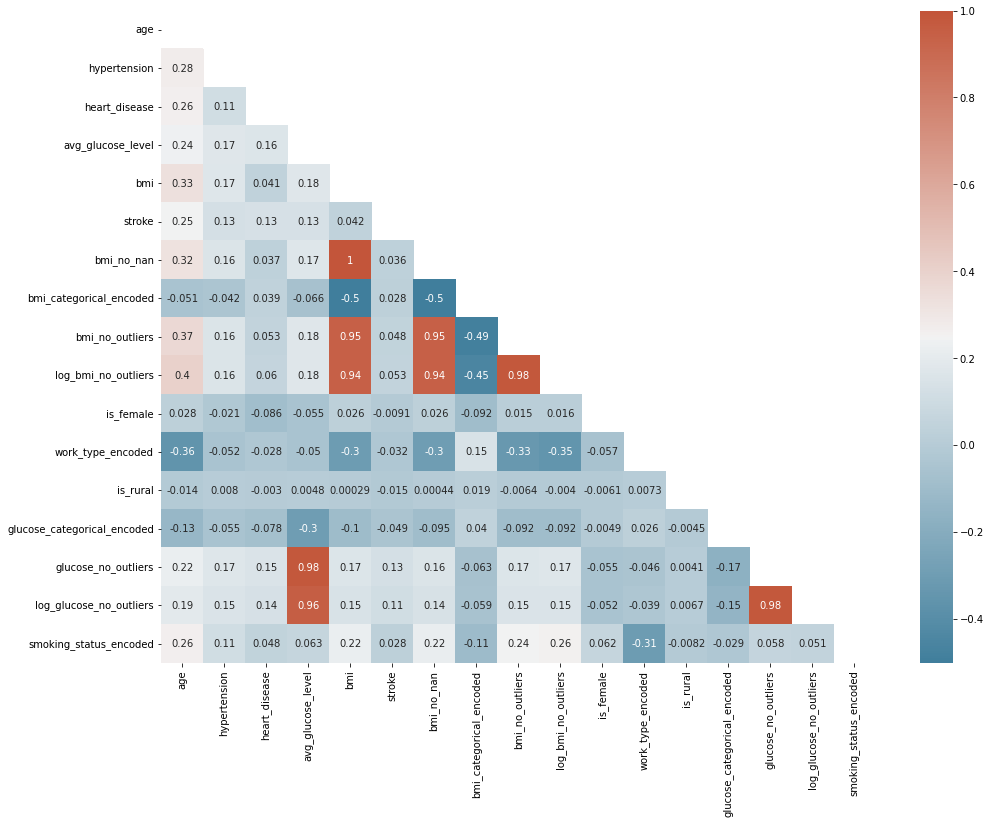

In [86]:
plotting(data=df_clear.loc[:,~df_clear.columns.isin(['id'])], x='none', type='heatmap')

Widoczna jest słaba korelacja między zmiennymi oraz między zmiennymi, a zmienną celu. Największe wartości widoczne są przy tych samych zmiennych, ale po przeprowadzeniu transformacji lub kodowania co jest rezultatem oczywistym. Jedyne zmienne, które są skorelowane na jakimś możliwie znaczącym poziomie to zmienna 'age', 'work_type', 'smoking_status', 'bmi' jednak wartości te nie są zbyt wysokie i nie występuje tutaj problem współliniowości. Ciężko także na tej podstawie dokonać selekcji zmiennych, więc raczej skorzystamy w późniejszym etapie z innych sposobów. 

### stroke
- zbalansowanie zbioru danych

In [ ]:
#wyciagniecie macierzy zmiennych X oraz wektora zmiennej celu Y
X = df_clear.loc[:,~df_clear.columns.isin(['stroke', 'bmi','gender', 'ever_married', 'work_type', 'Residence_type','smoking_status', 'bmi_categorical','glucose_categorical'])]
Y = df_clear.stroke

#train-test split, aby balansować tylko na zbiorze treningowym
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
df_imbalanced = X_train.copy()
df_imbalanced['stroke'] = y_train

In [ ]:
#plot ukazujacy problem niezbalansowanych danych - klasa pacjentow z udarem jest prawie niewidoczna
plotting(data = df_imbalanced, x='id', y='age', type='scatter')

#### SMOTE

SMOTE wykorzystuje podejście algorytmiczne KNN tj. dla każdej obserwacji **$x$** wybiera $k$ najbliższych sąsiadów i wybiera losowo jednego **$x'$** z nich. Następnie różnica między koordynatami **$x$** oraz **$x'$** jest obliczana i przemnożona losowo przez liczby z przedziału $(0,1)$. Tak stworzona z różnic obserwacja **$x''$** jest dodana do zbioru. Geometrycznie odwzorowuje to stworzenie nowej obserwacji na podstawie przesunięcia obserwacji bieżącej do jednego z sąsiadów.

In [57]:
# SMOTE
df_smote = balance_data(X=X_train, y=y_train, algorithm = 'SMOTE')
plotting(data = df_smote, x='id', y='age', type='scatter')

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.3332650972364381


0

#### ADASYN
ADASYN jest generalizacją algorytmu SMOTE, który ma za zadanie dokonać oversamplingu klasy mniejszościowej poprzez wygenerowanie sztucznych obserwacji. Ale różnica polega na tym, że bierze się pod uwagę rozkład gęstości $r_i$, który decyduje o liczbie syntetycznych instancji generowanych dla trudnych do nauczenia próbek. To główna różnica w porównaniu do SMOTE. Procedura jest następująca:
1. Ze zbioru danych dobierana jest całkowita liczba obserwacji z klasy większościowej $N^-$ oraz mniejszościowej $N^+$. Następnie ustawiany jest apriori threshold i jeżeli jest większy od wartości $d=N^+ / N^-$ to algorytm jest inicjowany. Całkowita liczba próbek do wygenerowania jest równa $G = (N^- - N^+)\times \beta$, gdzie $\beta = (N^+ / N^-)$. 
2. Dla każdej obserwacji mniejszościowej $x_i$ poszukiwane jest K-najbliższych sąsiadów w metryce Euklidesowej. Każda obserwacja $x_i$ powinna mieć inne otoczenie sąsiadów. Ustawiana jest wartość jest $r_i = \Delta i/k$, gdzie $\Delta i$ to ilość obserwacji z klasy większościowej w danym otoczeniu KNN, a $k$ to całkowita liczba sąsiadów. Następnie proporcja ta zostaje znormalizowana $r_x = r_i/\sum{r_i}$, gdzie $\sum{r_x} = 1$.  
3. Ostatecznie kalkulowana jest liczba sztucznych obserwacji do wygenerowania dla otoczenia $x_i$, która wynosi $g_i = r_x \times G$. Finalnie dla każdego otoczenia generowane są sztuczne próbki $s_i$ przykładowo przy pomocy $s_i = x_i + (x_{zi} - x_i)\lambda$, gdzie $x_{zi}$ jest kolejną obserwacją mniejszościową w otoczeniu, a $\lambda$ jest losową liczbą z przedziału $(0,1)$.

In [58]:
# ADASYN
df_ada = balance_data(X=X_train, y=y_train, algorithm='ADASYN')
plotting(data = df_ada, x='id', y='age', type='scatter')

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.3251139660174057


0

#### SMOTE Tomek
SMOTE + Tomek jest techniką hybrydową, która łączy technikę oversamplingu algorytmu SMOTE z techniką undersamplingu algorytmu Tomek. Po zastosowaniu SMOTE'a istnieje możliwość nakładania się klastrów klas co może skutkować w overfittingu. Wówczas użyty zostaje dodatkowo algorytm Tomek, który polega na sparowaniu ze sobą próbek z różnych klas, a następnie obserwacji z klasy większościowej zostają usunięte w celu (niekiedy z obydwu) wyraźniejszej separacji klas. 

In [59]:
# SMOTE Tomek
df_smtom = balance_data(X=X_train, y=y_train, algorithm='SMOTETOMEK')
plotting(data = df_smtom, x='id', y='age', type='scatter')

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.3184755961667038


0

#### SMOTE ENN
SMOTE + ENN jest techniką hybrydową, która polega na dodatkowym usunięciu pewnej liczby obserwacji z przestrzeni cech. Gdy zbiór zostanie poddany oversamplingu przez SMOTE to następnie zostaje zastosowana technika ENN, która jest techniką undersamplingu. ENN (Edited Nearest Neighbor) polega na odnalezieniu najbliższych K-sąsiadów każdej z obserwacji. Następnie sprawdza czy klasa większościowa tych sąsiadów jest zgodna z klasą danej obserwacji, jeśli nie to zarówno obserwacja jak i sąsiedzi zostają usunięci. Dzięki takiemu podejściu oddzielenie klas od siebie jest wyraźniejsze, aniżeli w pozostałych przypadkach. 

In [60]:
# SMOTE ENN
df_smenn = balance_data(X=X_train, y=y_train, algorithm='SMOTEENN')
plotting(data = df_smenn, x='id', y='age', type='scatter')

Procent klasy mniejszościowej do całości po zbalansowaniu:  0.2591559121032438


0

# Literatura
- http://cejsh.icm.edu.pl/cejsh/element/bwmeta1.element.desklight-002cb3e1-70f4-4321-a489-f4ced00e9d3b
- https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
